$$J=\mu-\frac{p_{||}}{k_i(t)}=\frac{m_e v_v^2}{2\omega_{ce}}-\frac{p_{||}}{k_i(t)}$$
$$v_v=\sqrt{\frac{2\omega_{ce}}{m_e}(J+\frac{p_{||}}{k_i(t)})}$$
$$\Omega=\frac{p_{||}}{k_i(t)}-\Pi_i$$
$$v_v=\sqrt{\frac{2\omega_{ce}}{m_e}(J+\Omega+\Pi_i)}$$
$$I=\iint v_v f_{trap} e^{i\xi}d\Omega d\xi$$
$$\chi=\frac{\omega_{pe}^2}{\omega(\Omega_e-\omega)}$$
$$I_{cold}=-\frac{i\omega}{4\pi}\chi E$$

In [317]:
import numpy as np
import os
import os.path as osp
import pickle
import matplotlib.pyplot as plt

In [318]:
def add(lis1,lis2):
    temp=[]
    for i in range(len(lis1)):
        temp.append(lis1[i]+lis2[i] if lis1[i] is not None and lis2[i] is not None else None)
    return temp
def sub(lis1,lis2):
    temp=[]
    for i in range(len(lis1)):
        temp.append(lis1[i]-lis2[i] if lis1[i] is not None and lis2[i] is not None else None)
    return temp
def cross(lis1,lis2):
    temp=[]
    for i in range(len(lis1)):
        temp.append(lis1[i]*lis2[i] if lis1[i] is not None and lis2[i] is not None else None)
    return temp
def div(lis1,lis2):
    temp=[]
    for i in range(len(lis1)):
        temp.append(lis1[i]/lis2[i] if lis1[i] is not None and lis2[i] is not None else None)
    return temp
def operate(f,A):
    return [f(i) if i is not None else None for i in A]
def min_(A):
    a=[]
    for i in A:
        if i:
            a.append(i)
    return min(a)

In [319]:
root="/home/wzy/segment-anything/data/source_data4/scan_gradB/fc256"
res_dir="/home/wzy/segment-anything/outputs/4/fc256/mask_res"
time=6
# zqs = [31,401,1001,10]
zqs = [31,401,251,10]
# zqs = [31,401,501,8]
# zqs = [31,401,501,10]
cnum=np.prod(zqs)
bs = cnum*8
offset = 0
dist = np.reshape(np.fromfile(osp.join(root,"dist.bin"),offset=offset,count=cnum),zqs,'F')
dist=dist.transpose(2,3,0,1)
print(dist.shape)
chor_lis=np.loadtxt(osp.join(root,"chorus.out"))
# chor_lis=chor_lis.reshape(1002,1000,2).transpose(1,0,2)
# chor_lis=chor_lis.reshape(738,502,2)
chor_lis=chor_lis.reshape(dist.shape[1]*100,dist.shape[0]+1,2)
print(chor_lis.shape)
k_lis=np.loadtxt(osp.join(root,"kmode.out"))
print(k_lis.shape)
gyro_lis=np.loadtxt(osp.join(root,"gyro.out"))
print(gyro_lis.shape)
Jact_lis=np.loadtxt(osp.join(root,"Jact.out"))
print(Jact_lis.shape)
vr_lis=np.loadtxt(osp.join(root,"vr.out"))
print(vr_lis.shape)
zpos_lis=np.loadtxt(osp.join(root,"zpos.out"))
print(zpos_lis.shape)
# sour_lis=np.loadtxt(osp.join(root,"source.out"))
# sour_lis=sour_lis.reshape(1000,1002,2)
# print(sour_lis.shape)

(251, 10, 31, 401)
(1000, 252, 2)
(251,)
(251,)
(251,)
(251,)
(251,)


In [320]:
49823448/31/401/501

8.0

In [321]:
740952/2/502

738.0

In [322]:
wl=0.30328825168137874/5
vperp0=0.3
nh=0.02
gyro0=0.2
def f_Pi(vr, kmode):
    return vr/kmode
def S_inte(f, mask:np.ndarray, x_range=[0,2*np.pi],y_range=[-0.1,0.1]):
    y_len, x_len = mask.shape
    x_lis=np.linspace(x_range[0],x_range[1],x_len)
    y_lis=np.linspace(y_range[0],y_range[1],y_len)
    dj=f(x_lis,y_lis[:,None])*mask
    f=np.trapz(dj,x_lis)
    fg = np.trapz(f,y_lis)
    return fg

def current(f_trap,mask_origin,J,Pi,omega_ce,ks,x_range=[0,2*np.pi],y_range=[-0.1,0.1]):
    f_trap=np.transpose(f_trap)
    mask_origin=np.transpose(mask_origin)

    coef=ks*nh*vperp0**2/gyro0*np.exp(1)
    def v_ver(Omega):
        return np.sqrt(2*omega_ce*(J+Omega+Pi))
    def f(x,y):
        return v_ver(y)*f_trap*np.exp(1j*x)
    return -coef*S_inte(f,mask_origin,x_range=x_range,y_range=y_range)
def current2(gyro,A):
    A=A[0]+1j*A[1]
    xi=1/(wl*(gyro-wl))
    j=-1j*(wl/4*np.pi)*xi*wl*A
    return j


In [323]:
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))


In [324]:
# 计算电流

In [325]:
chor_lis.shape

(1000, 252, 2)

/tmp/ipykernel_184252/1049814015.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*omega_ce*(J+Omega+Pi))


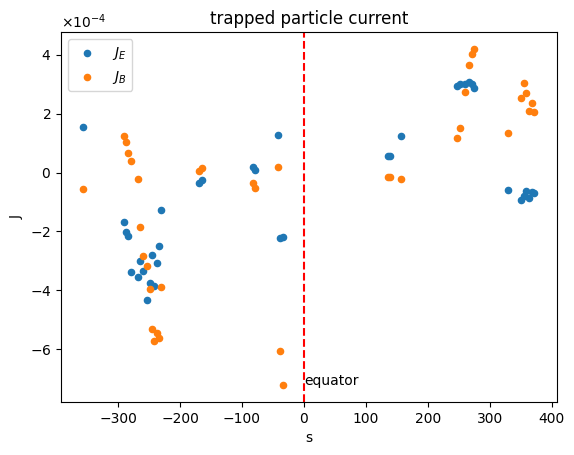

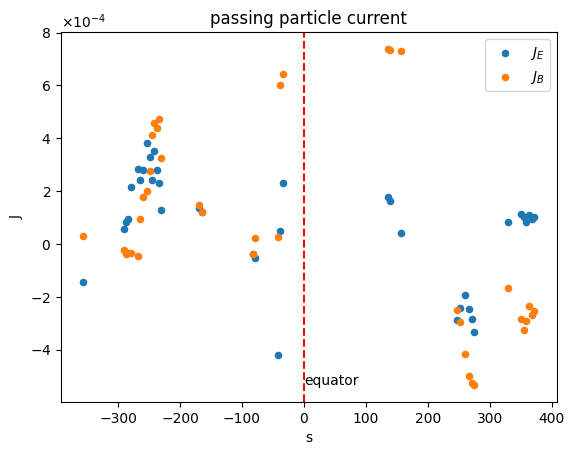

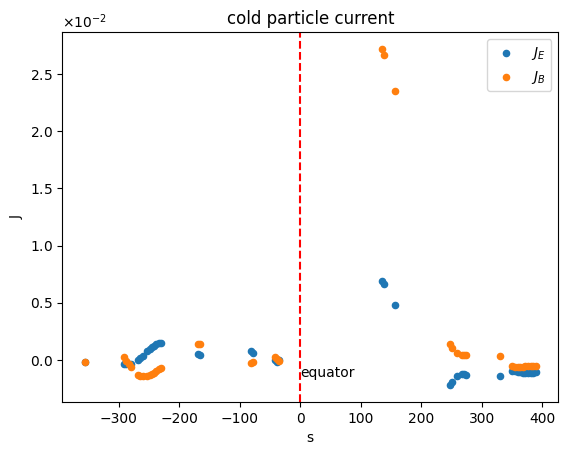

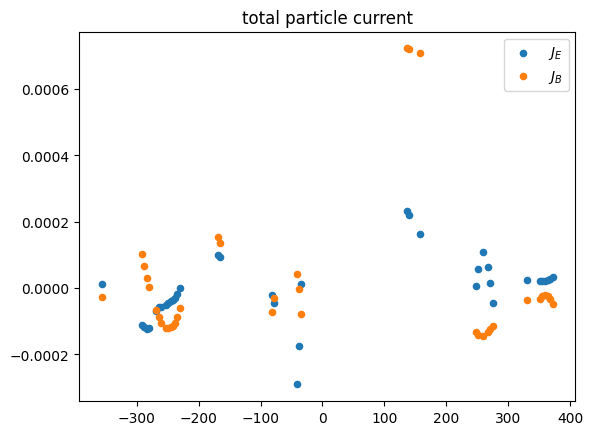

In [326]:
time=time
s=600
trapped_current_lis=[]
passing_current_lis=[]
cold_current_lis=[]
all_current_lis=[]
for s in range(dist.shape[0]):
    f_trap=dist[s,time,:,:]
    f_trap_2cir=np.concatenate((f_trap,f_trap),axis=0)
    file_path=osp.join(res_dir,f"{time}_{s}_True.pkl")
    if osp.exists(file_path):
        with open(file_path,"rb") as fp:
            mask,is_construct=pickle.load(fp)
            # print(1-mask+mask)
            # break
        real_time=time*100+99
        J=Jact_lis[s]
        Pi=f_Pi(vr_lis[s],k_lis[s])
        omega_ce=gyro_lis[s]
        ks=k_lis[s]
        trapped_current=current(f_trap_2cir,mask,J,Pi,omega_ce,ks,x_range=[0,4*np.pi],y_range=[-0.3,0.3])
        trapped_current_lis.append(trapped_current)
        all_current=current(f_trap_2cir,1-mask+mask,J,Pi,omega_ce,ks,x_range=[0,4*np.pi],y_range=[-0.3,0.3])
        all_current_lis.append(all_current/2)
        passing_current_lis.append(all_current/2-trapped_current)
        cold_current=current2(gyro_lis[s],chor_lis[real_time][s])
        cold_current_lis.append(cold_current)
    else:
        passing_current_lis.append(None)
        trapped_current_lis.append(None)
        cold_current_lis.append(None)
        all_current_lis.append(None)
def scatter(x_lis, y_lis, s=20):
    x=[]
    y=[]
    for i in range(len(x_lis)):
        if y_lis[i] is not None:
            x.append(x_lis[i])
            y.append(y_lis[i])
    # print(y)
    plt.scatter(x,y,s=s)

space_lis=zpos_lis[:dist.shape[0]]

plt.figure()
scatter(space_lis,[np.real(i) if i is not None else None for i in trapped_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in trapped_current_lis])
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min([np.imag(i) if i!=None else 0 for i in trapped_current_lis]), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.title(f"time={time} trapped")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("trapped particle current")
plt.show()
plt.figure()
scatter(space_lis,[np.real(i) if i!=None else None for i in passing_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in passing_current_lis])
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min([np.imag(i) if i!=None else 0 for i in passing_current_lis]), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.title(f"time={time} passing")
plt.title("passing particle current")
plt.legend([r"$J_E$",r"$J_B$"])
plt.show()
plt.figure()
scatter(space_lis,[np.real(i) if i!=None else None for i in cold_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None  for i in cold_current_lis])
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min([np.imag(i) if i!=None else 0 for i in cold_current_lis]), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.title(f"time={time} cold")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("cold particle current")
plt.show()
current_lis=[]
for i in range(len(passing_current_lis)):
    if passing_current_lis[i] is not None:
        current_lis.append(passing_current_lis[i]+trapped_current_lis[i])
    else:
        current_lis.append(None)
plt.figure()
scatter(space_lis,[np.real(i) if i is not None else None for i in all_current_lis])
scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
plt.title(f"time={time}")
plt.legend([r"$J_E$",r"$J_B$"])
plt.title("total particle current")
plt.show()


In [327]:
import numpy as np
from scipy.optimize import curve_fit

# 定义线性模型函数
def linear_model(x, a):
    return a * x

def fit_current(trapped,passing):
    _trapped=[]
    _passing=[]
    for i,j in zip(trapped,passing):
        if i and j and not np.isnan(i) and not np.isnan(j):
            _trapped.append(i)
            _passing.append(j)
    x_data,y_data=np.array(_trapped),np.array(_passing)
    popt, pcov = curve_fit(linear_model, x_data, y_data)
    a_fit = popt[0]
    return round(a_fit,2)


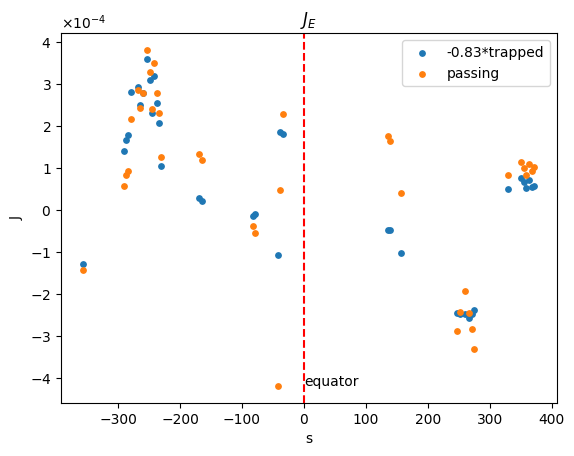

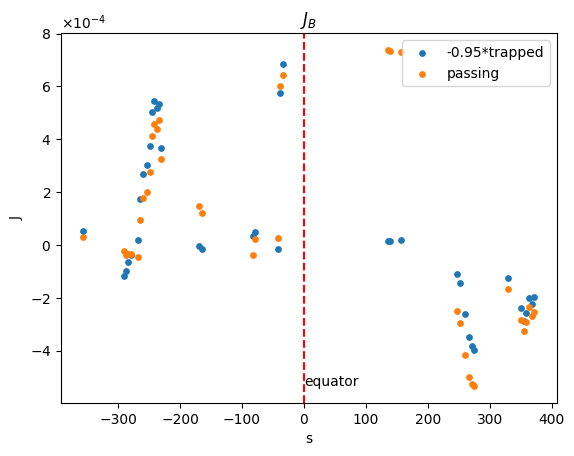

In [328]:
# 拟合比例

# 比较理论值与我们的计算值
# sour=sour_lis[600+99,:,:]
# plt.figure()
# scatter(space_lis,sour[:,1],s=5)
# # scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
# scatter(space_lis,[np.imag(i) if i is not None else None for i in all_current_lis],s=5)
# plt.title(f"time={time}")
# plt.legend([r"theoretical value",r"our value"])
# plt.title(r"$J_B$")
# plt.show()

# 拟合trapped和total的比例
# sour=sour_lis[600+99,:,:]
# plt.figure()
# scatter(space_lis,[np.imag(i) if i is not None else None for i in trapped_current_lis],s=15)
# # scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
# scatter(space_lis,[-0.9*np.imag(i) if i is not None else None for i in all_current_lis],s=15)
# plt.title(f"time={time}")
# plt.legend([r"trapped",r"-0.9*total"])
# plt.title(r"$J_B$")
# plt.show()

# 拟合trapped和passing的比例 J_E
# sour=sour_lis[600+99,:,:]
cut=0
a=fit_current(operate(np.real,trapped_current_lis[cut:]),operate(np.real,passing_current_lis[cut:]))
plt.figure()
scatter(space_lis,[a*np.real(i) if i is not None else None for i in trapped_current_lis],s=15)
# scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
scatter(space_lis,[np.real(i) if i is not None else None for i in passing_current_lis],s=15)
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min([np.real(i) if i is not None else 0 for i in passing_current_lis]), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.title(f"time={time}")
plt.legend([f"{a}*trapped",r"passing"])
plt.title(r"$J_E$")
plt.show()

# 拟合trapped和passing的比例 J_B
a=fit_current(operate(np.imag,trapped_current_lis[cut:]),operate(np.imag,passing_current_lis[cut:]))
plt.figure()
scatter(space_lis,[a*np.imag(i) if i is not None else None for i in trapped_current_lis],s=15)
# scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
scatter(space_lis,[np.imag(i) if i is not None else None for i in passing_current_lis],s=15)
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min([np.imag(i) if i is not None else 0 for i in passing_current_lis]), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.title(f"time={time}")
plt.legend([f"{a}*trapped",r"passing"])
plt.title(r"$J_B$")
plt.show()

# 比较A和J_E
# plt.figure()
# scatter(space_lis,[np.real(i) if i is not None else None for i in chor_lis[699,:,1]],s=15)
# # scatter(space_lis,[np.imag(i) if i!=None else None for i in all_current_lis])
# scatter(space_lis,[5*np.imag(i) if i is not None else None for i in passing_current_lis],s=15)
# plt.title(f"time={time}")
# plt.legend([r"A",r"5*$J_E$"])
# plt.title(r"passing")
# plt.show()


In [329]:
id1=np.argmax(chor_lis[699,:,0])
passing=[5*np.real(i) if i is not None else None for i in passing_current_lis]
id2=passing.index(max([5*np.real(i) if i is not None else 0 for i in passing_current_lis]))
id2-id1

2

In [330]:
def find_local_maxima(data, window_size):
    local_maxima = []
    n = len(data)
    
    if n <= window_size:
        return local_maxima
    
    for i in range(window_size, n - window_size):
        if data[i] > max(data[i-window_size:i]) and data[i] > max(data[i+1:i+window_size+1]):
            local_maxima.append((i, data[i]))
    
    return sorted(local_maxima,key=lambda x:x[1])

local_maxima = find_local_maxima(chor_lis[699,:,0], 10)
print("所有的局部极大值：", local_maxima)


所有的局部极大值： [(204, -0.0012643723450357074), (26, 0.000679512374643612), (90, 0.0011164396809770236), (224, 0.0021387279241807337), (120, 0.003636139515192117), (51, 0.004549100301757216)]


In [331]:
def redefas(A,B):
    return [i if B[num] is not None else None for num,i in enumerate(A)]

In [332]:
def delta(A,B):
    return [i-j if (i is not None and j is not None) else None for i,j in zip(A,B)]
def fixasphase(A):
    lis=[]
    for i in A:
        if i is None:
            lis.append(None)
        else:
            lis.append(i+2*np.pi if i<0 else i)
    return lis

In [333]:
# 计算 passing，trapped，cold 在 a，a垂直 方向的分量

In [334]:
passing_angle_lis=[np.angle(i) if i is not None else None for i in passing_current_lis]
trapped_angle_lis=[np.angle(i) if i is not None else None for i in trapped_current_lis]
cold_angle_lis=[np.angle(i) if i is not None else None for i in cold_current_lis]
all_angle_lis=[np.angle(i) if i is not None else None for i in all_current_lis]
a_lis=np.array(chor_lis[100*time+99,:,:])
print(a_lis.shape)
a_lis=a_lis[:,0]+1j*a_lis[:,1]
a_lis=a_lis[1:]
a_angle_lis=[np.angle(i) if i is not None else None for i in a_lis]
ia_angle_lis=[np.angle(i) if i is not None else None for i in 1j*a_lis]

(252, 2)


In [335]:
# 计算j和total  A  iA的相位差
passing_delta_angle=sub(passing_angle_lis,a_angle_lis)
trapped_delta_angle=sub(trapped_angle_lis,a_angle_lis)
all_delta_angle=sub(all_angle_lis,a_angle_lis)
passing_a=cross(operate(np.abs,passing_current_lis),operate(np.cos,passing_delta_angle))
passing_aperp=cross(operate(np.abs,passing_current_lis),operate(np.sin,passing_delta_angle))
trapped_a=cross(operate(np.abs,trapped_current_lis),operate(np.cos,trapped_delta_angle))
trapped_aperp=cross(operate(np.abs,trapped_current_lis),operate(np.sin,trapped_delta_angle))
all_a=cross(operate(np.abs,all_current_lis),operate(np.cos,all_delta_angle))
all_aperp=cross(operate(np.abs,all_current_lis),operate(np.sin,all_delta_angle))

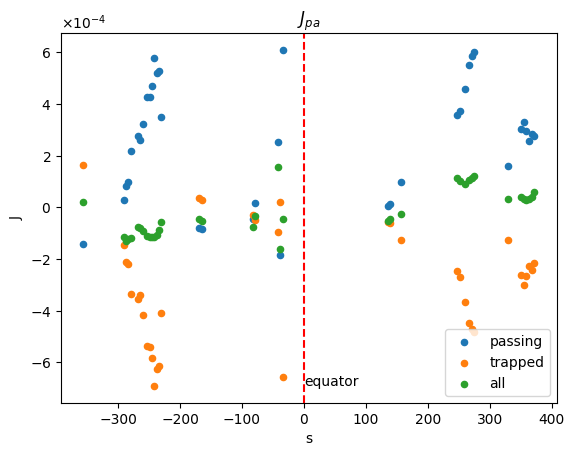

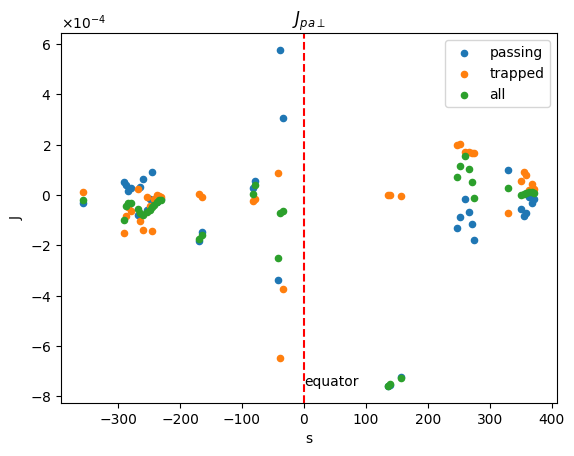

In [336]:
plt.figure()
scatter(space_lis,passing_a)
scatter(space_lis,trapped_a)
scatter(space_lis,all_a)
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min(min_(passing_a),min_(trapped_a)), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.legend(["passing","trapped","all"])
plt.title(r"$J_{pa}$")
plt.show()

plt.figure()
scatter(space_lis,passing_aperp)
scatter(space_lis,trapped_aperp)
scatter(space_lis,all_aperp)
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min(min_(trapped_aperp),min_(passing_aperp)), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel("J")
plt.legend(["passing","trapped","all"])
plt.title(r"$J_{pa\perp}$")
plt.show()

In [337]:
fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),passing_angle_lis))[650:750]

[]

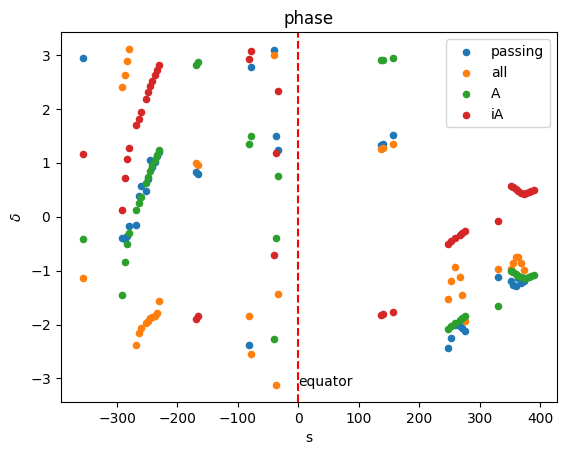

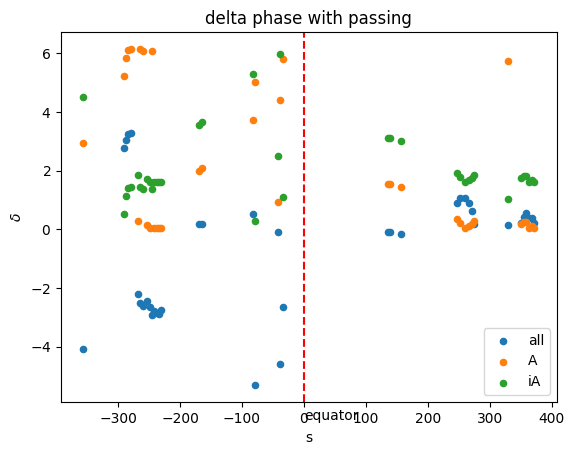

In [338]:
plt.figure()
scatter(space_lis,passing_angle_lis)
scatter(space_lis,all_angle_lis)
scatter(space_lis,redefas(a_angle_lis,passing_angle_lis))
scatter(space_lis,redefas(ia_angle_lis,passing_angle_lis))
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, -3.14, 'equator', ha='left')
plt.xlabel("s")
plt.ylabel(r"$\delta$")
plt.legend(["passing","all","A","iA"])
plt.title("phase")
plt.show()

plt.figure()
scatter(space_lis,(delta(all_angle_lis,passing_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),passing_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(ia_angle_lis,passing_angle_lis),passing_angle_lis)))
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, -6.5, 'equator', ha='left')
plt.xlabel("s")
plt.ylabel(r"$\delta$")
plt.legend(["all","A","iA"])
plt.title("delta phase with passing")
plt.show()

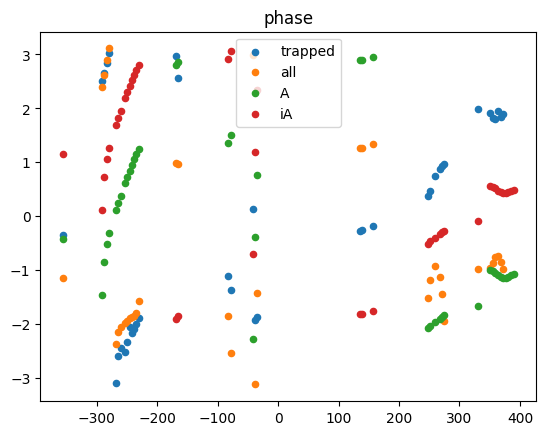

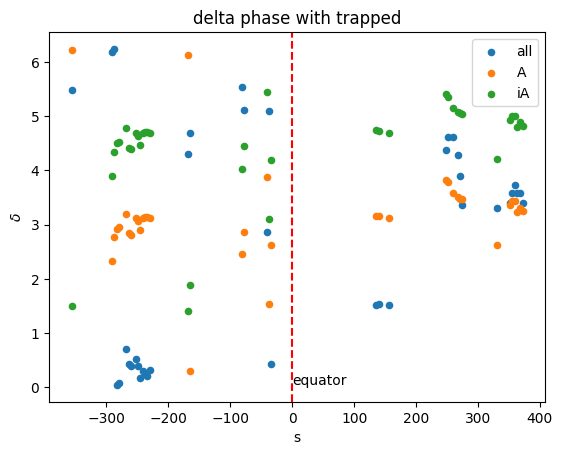

In [339]:
plt.figure()
scatter(space_lis,trapped_angle_lis)
scatter(space_lis,all_angle_lis)
scatter(space_lis,redefas(a_angle_lis,trapped_angle_lis))
scatter(space_lis,redefas(ia_angle_lis,trapped_angle_lis))
plt.legend(["trapped","all","A","iA"])
plt.title("phase")
plt.show()

plt.figure()
scatter(space_lis,fixasphase(delta(all_angle_lis,trapped_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),trapped_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(ia_angle_lis,passing_angle_lis),trapped_angle_lis)))
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min(min_(fixasphase(delta(all_angle_lis,trapped_angle_lis))),
                     min_(fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),trapped_angle_lis))),
                     min_(fixasphase(delta(redefas(ia_angle_lis,passing_angle_lis),trapped_angle_lis)))), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel(r"$\delta$")
plt.legend(["all","A","iA"])
plt.title("delta phase with trapped")
plt.show()

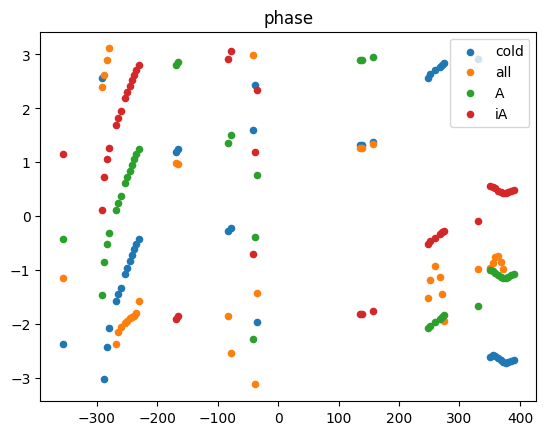

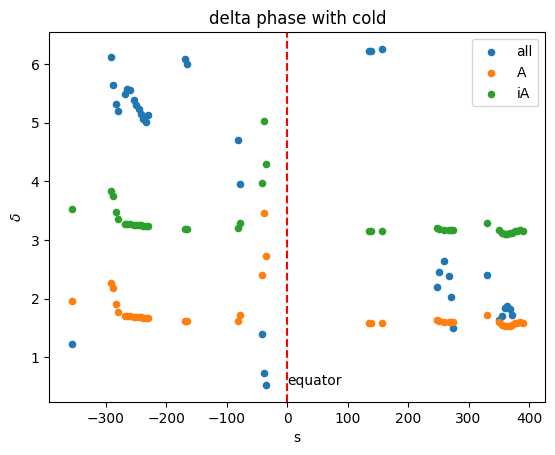

In [340]:
plt.figure()
scatter(space_lis,cold_angle_lis)
scatter(space_lis,all_angle_lis)
scatter(space_lis,redefas(a_angle_lis,cold_angle_lis))
scatter(space_lis,redefas(ia_angle_lis,cold_angle_lis))
plt.legend(["cold","all","A","iA"])
plt.title("phase")
plt.show()

plt.figure()
scatter(space_lis,fixasphase(delta(all_angle_lis,cold_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),cold_angle_lis)))
scatter(space_lis,fixasphase(delta(redefas(ia_angle_lis,passing_angle_lis),cold_angle_lis)))
plt.gca().yaxis.set_major_formatter(formatter)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, min(min_(fixasphase(delta(all_angle_lis,cold_angle_lis))),
                     min_(fixasphase(delta(redefas(a_angle_lis,passing_angle_lis),cold_angle_lis))),
                     min_(fixasphase(delta(redefas(ia_angle_lis,passing_angle_lis),cold_angle_lis)))), 'equator', ha='left')
plt.xlabel("s")
plt.ylabel(r"$\delta$")
plt.legend(["all","A","iA"])
plt.title("delta phase with cold")
plt.show()

In [341]:
alpha=np.array([-1.25,-1.48,-1.7,-1.91,-1.59])
fc=[1,16,64,128,256]

Text(0.5, 1.0, 'passing/trapped')

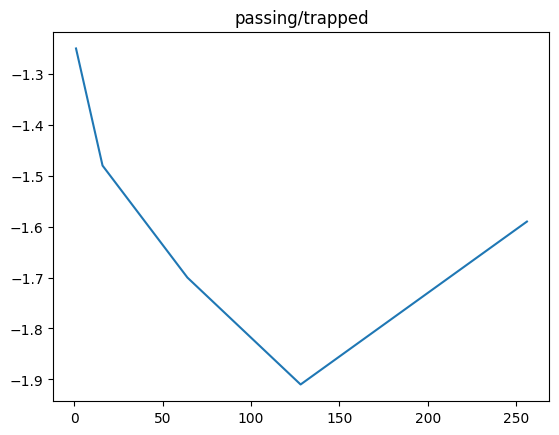

In [342]:
plt.plot(fc,alpha)
plt.title('passing/trapped')